LSTM model architecture 2:

First working model (previous one didn't produce lyrics correctly) with and Embedding layer, a Bidirectional LSTM layer, a dropout layers to avoid overfitting and a dense layer.



Also includes function that outputs most used words in the Vocabulary.

Has a basic lyric generator that can be improved. Maybe we can create a loss function which favours rhyme or look at creating bars line by line. The problem with this was bars ending in words like 'i' and 'the' as lines were getting cut short.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from google.colab import files
from google.colab import drive
import numpy as np
#@title Import Statements`
!pip install PyGithub

# Package Imports
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from urllib.request import urlopen # The default requests package
import requests # For making GitHub requests
from pprint import pprint # For pretty printing
from pathlib import Path # The Path class

# For the more advanced requests
import base64
import os
import sys
sys.path.append("./PyGithub");
from github import Github
from getpass import getpass


     |████████████████████████████████| 296kB 8.3MB/s 


In [ ]:
#@title Function Definitions
# Recursively Import the Data (AUTOMATIC)

def _decode_and_write(file__, path_):
    data = file__.decoded_content
    data = data.decode('utf-8')[1:]
    with open(path_, 'w') as writefile:
        writefile.write(data) 
    data = data.splitlines()
    data_rows = []
    for count, word in enumerate(data):
        if count>0:
            data_rows.append(word.split(','))
    data = pd.DataFrame(data_rows)
    data = data.to_numpy()
    return data


def import_github(path_name="AllLyrics.txt"):
    """
    Function for importing the github file
    path_name: str
    output: None
    """
    g = Github(getpass("Enter your PAT key ")) # Enter your PAT Key.
    username = "MikeMNelhams"
    main_branch_bool = input("Main Branch: Yes or No? ")
    yes_synonyms = ["yes", "y", "yh", "1", "true"]
    if main_branch_bool.lower() in yes_synonyms: 
        branch = "master" 
    else: 
        branch = "PROTOTYPE"

    user = g.get_user(username)
    r_proj_clone = 0
    for repo in g.get_user().get_repos():
        if repo.name == "ai-group-project-Team-JMJM":
            r_proj_clone = repo
            break
        # To see all the available attributes and methods
        print(dir(repo))
    if not r_proj_clone:
        print("ai-group-project-Team-JMJM not found")
        sys.exit()
    print("Importing Github cleaned text files...")
    contents = r_proj_clone.get_contents("RapLyrics/CLEAN", ref=branch)
    RAP_DATA = []
    for file_ in contents:
        path = file_.path
        path = str(path) 
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the Lyrics
            RAP_DATA.append(file_.decoded_content.decode("utf-8")) 
    
    temp_path = Path(path_name)
    if temp_path.is_file(): 
        if os.stat(path_name).st_size == 0:
            write_bool2 = True
        else: 
            write_bool2 = False
    else: 
        write_bool2 = True
    
    if write_bool2: 
        for lyric in RAP_DATA: 
            try:
                with open(path_name, 'w') as writefile: 
                    writefile.write(lyric)
            except: 
                print("Error, file moved/deleted during write")
        print("{} is now up to date!".format(path_name))
    else: 
        print("{} is already up to date!".format(path_name))
    
    contents = r_proj_clone.get_contents("RapLyrics/Other", ref=branch)
    for counter, file_ in enumerate(contents):
        path = file_.path
        path = str(path) 

        title_start = path.find('Other')
        title_len = path[title_start:].find('.')
        path = path[title_start + 6:title_start + title_len + 4]

        print("Writing file {} {}".format(counter, path))
        temp_path = Path(path)
        if temp_path.is_file():
            with open(path,'w'): pass # Cheeky way to clear the file if it exists
        
        # Split the long string into a list of lines, then split by words, then put into a csv, then to numpy array 
        data = file_.decoded_content
        data = data.decode('utf-8')[1:]

        with open(path, 'w') as writefile:
            writefile.write(data) 
        print("All files now up to date!")


def update_github(write_bool=False, path_name="AllLyrics.txt"):
    """
    Function for updating the github file, by cleaning the lyrics, optional write to txt file. 
    write_bool: bool
    path_name: str
    output: None
    """
    g = Github(getpass("Enter your PAT key ")) # Enter your PAT Key.
    username = "MikeMNelhams"
    main_branch_bool = input("Main Branch: Yes or No? ")
    yes_synonyms = ["yes", "y", "yh", "1", "true"]
    if main_branch_bool.lower() in yes_synonyms: 
        branch = "master" 
    else: 
        branch = "PROTOTYPE"

    user = g.get_user(username)
    r_proj_clone = 0
    for repo in g.get_user().get_repos():
        if repo.name == "ai-group-project-Team-JMJM":
            r_proj_clone = repo
            break
        # To see all the available attributes and methods
        print(dir(repo))
    
    if not r_proj_clone:
        print("ai-group-project-Team-JMJM not found")
        sys.exit()

    print("Importing editing csv files...")

    # Split the long string into a list of lines, then split by words, then put into a csv, then to numpy arr
    contents = r_proj_clone.get_contents("RapLyrics/Other", ref=branch)
    for counter, file_ in enumerate(contents):
        path = file_.path 
        path = str(path)
        title_start = path.find('Other')
        title_len = path[title_start:].find('.')
        name = path[title_start + 6:title_start + title_len + 4]
        print("Writing file {} {}".format(counter, name))
        if name.lower() == "censors.csv":
            censors = _decode_and_write(file_, path)
        elif name.lower() == "capitals.csv":
            capitals = _decode_and_write(file_, path)
        else: 
            _decode_and_write(file_, path)
    print("All editing csv files are up to date!")

    print("Importing Github uncleaned text files...")
    contents = r_proj_clone.get_contents("RapLyrics/UNCLEAN", ref=branch)

    RAP_DATA = []
    rap_lyric_names = []

    for file_ in contents:
        path = file_.path
        path = str(path) 
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the name
            title_start = path.find('UNCLEAN')
            title_len = path[title_start:].find('.')
            name = path[title_start + 8:title_start + title_len]
            if name[-2:] == 'UC':
                name = name[:-2]
            rap_lyric_names.append(name) 

        # Append the Lyrics
        RAP_DATA.append(file_.decoded_content.decode("utf-8")) 
        
    # Remove the \ufeff at the beginning O(n)
    for count, lyric in enumerate(RAP_DATA): 
        RAP_DATA[count] = lyric[1:]

    # Censor the profanities O(n*m + n*m2) m > m2 xor m2 > m
    for count in range(len(RAP_DATA)): 
        for i in range(len(censors[0:])):
            RAP_DATA[count] = RAP_DATA[count].replace(str(censors[i, 0]), str(censors[i, 1]))
        for i in range(len(capitals[0:])):
            RAP_DATA[count] = RAP_DATA[count].replace(str(capitals[i, 0]), str(capitals[i, 1]))

    contents = r_proj_clone.get_contents("RapLyrics/CLEAN", ref=branch)
    cleaned_names = []
    for counter, file_ in enumerate(contents):
        path = file_.path
        path = str(path) 
        print("File {} ".format(counter + 1) + path)
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the name
            title_start = path.find('CLEAN')
            title_len = path[title_start:].find('.')
        name = path[title_start + 6:title_start + title_len]
        if name[-2:] == 'CL':
            name = name[:-2]
        cleaned_names.append(name) 

    # ALL OF THE EDITING IS DONE IN THE 'PROTOTYPE BRANCH' to avoid overwriting import changes
    # If the (now cleaned) rap_lyrics name is new (not in cleaned_names), then we want to create that as a new file 
    # If the (now cleaned) rap_lyrics name is NOT new (not in cleaned_names), then we want to update the file
    # print(rap_lyric_names)
    # print(cleaned_names)
    print("Commiting files to github...")
    for counter, new_name in enumerate(rap_lyric_names): 
        if new_name in cleaned_names: 
            duplicate = r_proj_clone.get_contents("RapLyrics/CLEAN/{}CL.txt".format(new_name), ref=branch)
            r_proj_clone.update_file("RapLyrics/CLEAN/{}CL.txt".format(new_name), "This was uploaded automatically via pipeline", RAP_DATA[counter], duplicate.sha, branch=branch)
        else:
            r_proj_clone.create_file("RapLyrics/CLEAN/{}CL.txt".format(new_name), "This was uploaded automatically via pipeline", RAP_DATA[counter], branch=branch)

    if write_bool: 
        print("Writing text file to: {}".format(path_name))
        with open(path_name, 'w') as writefile:
            for lyric in RAP_DATA:
                writefile.write(lyric)

In [ ]:
# Import all of Mike's lyrics.import_github()

Enter your PAT key ··········
Main Branch: Yes or No? Yes
Importing Github cleaned text files...
AllLyrics.txt is now up to date!
Writing file 0 capitals.csv
All files now up to date!
Writing file 1 censors.csv
All files now up to date!
Writing file 2 censors2.csv
All files now up to date!


In [ ]:
Text = open("AllLyrics.txt", "r").read()
# turn text to lower case to reduce vocabulary
Text = Text.lower()
with open("AllLyrics.txt", "r") as f:
    content = f.readlines()
# bars is a list containing each line in dataset in lowercase
bars = [x.strip().lower() for x in content]
stripped_bars = [word.split() for word in bars]
# Vocabulary is a list of all words in the dataset
Vocabulary = ''.join([i for i in Text]).replace("\n"," ").split(' ')

In [ ]:
# The numbers of bars in our dataset, 5283
no_of_bars = len(bars)
print(no_of_bars)

14184


In [ ]:
# word_count is a function creating a list of words ranked in order of most used
# could think about removing certain words to create more accurate raps as model won't learn well from words used very infrequently
def word_count(lyrics):
  a = {}
  for word in Vocabulary:
    if word in a:
      a[word] += 1
    else:
      a[word] = 1
  return a
word_dict = word_count(Vocabulary)
sort_dict = sorted(word_dict.items(), key = lambda x: x[1], reverse = True)
# Top 20 words
sort_dict1 = sort_dict[:40]

In [ ]:
from collections import Counter
  
def removeElements(lst, k):
    counted = Counter(lst)
    kept_words = [word for word in lst if counted[word] >= k]
    removed_words = [word for word in lst if counted[word] < k]
    return kept_words, removed_words

In [ ]:
kept_words, removed_words = removeElements(Vocabulary, 3 )
print(len(removed_words), len(kept_words))
split_bar = [word.split() for word in bars]
split_bar
kept_bars = [bar for bar in split_bar if not any(embedded_word in bar for embedded_word in removed_words)]

8254 96064


In [ ]:
# Need to create dictionary listing the words in alphabetical order so we can assign unique integers to each word
# Neural networks take in integers, not words
words1 = sorted(list(set(kept_words)))
words = [str(i) for i in words1]
# Create a dictionary whereby we can convert words into integers
word_to_int = { str(words[i]) : i for i in range(len(words))}
# Need to reverse this at the end to reverse numbers back into words
int_to_word = { i : words[i] for i in range(len(words))}

In [ ]:
# Number of unique words in our dataset
vocab_size = len(words) + 1
print(vocab_size)

3082


In [ ]:
# Define a function that converts sentences into a sequence of corresponding integers
def sentence_to_integer(bar):
    seq = []
    seq.append([word_to_int[word] for word in bar])
    seq = sum(seq, [])
    return seq

In [ ]:
# Want to convert bars into n-grams of increasing length
# So we start with the first two words and create lists of increasing length after adding the next word
sequences = []
for line in kept_bars:
  token_list = sentence_to_integer(line)
  for i in range(1, len(token_list)):
      n_gram_seq = token_list[:i+1]
      sequences.append(n_gram_seq)
sequences

[[2803, 2642],
 [2803, 2642, 914],
 [2803, 2642, 914, 1106],
 [714, 1359],
 [714, 1359, 150],
 [3046, 2169],
 [3046, 2169, 1744],
 [3046, 2169, 1744, 152],
 [3046, 2169, 1744, 152, 976],
 [3046, 2169, 1744, 152, 976, 1626],
 [2936, 708],
 [2936, 708, 3059],
 [2936, 708, 3059, 2866],
 [2936, 708, 3059, 2866, 1626],
 [2936, 708, 3059, 2866, 1626, 2707],
 [2936, 708, 3059, 2866, 1626, 2707, 2169],
 [2936, 708, 3059, 2866, 1626, 2707, 2169, 1359],
 [2936, 708, 3059, 2866, 1626, 2707, 2169, 1359, 150],
 [2135, 1231],
 [2783, 123],
 [2954, 747],
 [2954, 747, 3059],
 [2954, 747, 3059, 2038],
 [2954, 747, 3059, 2038, 1626],
 [2954, 747, 3059, 2038, 1626, 1848],
 [2954, 747, 3059, 2038, 1626, 1848, 2408],
 [2954, 747, 3059, 2038, 1626, 1848, 2408, 1736],
 [2919, 3059],
 [2919, 3059, 2864],
 [2919, 3059, 2864, 1209],
 [2919, 3059, 2864, 1209, 150],
 [2038, 1626],
 [2038, 1626, 1848],
 [2038, 1626, 1848, 2408],
 [2038, 1626, 1848, 2408, 1831],
 [2038, 1626, 1848, 2408, 1831, 2642],
 [2038, 1626, 

In [ ]:
# We need to pad each line so that each line is of equal length for our model
# Thus need to find max length of a bar so we can pad all bars to this length
padding_length = max([len(line) for line in sequences])
print(padding_length)

18


In [ ]:
if '213' in kept_words:
  print('yes')

yes


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = np.array(pad_sequences(sequences, maxlen = padding_length, padding = 'pre'))
# Remove last word from each line
x_train = sequences[:,:-1]
# Last word is used as the label
y_train = sequences[:,-1]
print(x_train[3])
print(y_train[3])
# one hot encode the the outputs 
y_train = tf.keras.utils.to_categorical(y_train, num_classes = vocab_size)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 714]
1359


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, 512, input_length = padding_length - 1))
model.add(Bidirectional(LSTM(256, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'nadam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 512)           576512    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 512)           1574912   
_________________________________________________________________
dropout (Dropout)            (None, 17, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1126)              1154150   
Total params: 7,503,974
Trainable params: 7,503,974
Non-trainable params: 0
______________________________________________

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.15, epochs = 50, batch_size = 256)

Epoch 1/50
59/59 [==============================] - 18s 166ms/step - loss: 6.2252 - accuracy: 0.0286 - val_loss: 5.8918 - val_accuracy: 0.0296
Epoch 2/50
59/59 [==============================] - 8s 134ms/step - loss: 5.7735 - accuracy: 0.0455 - val_loss: 5.5358 - val_accuracy: 0.0615
Epoch 3/50
59/59 [==============================] - 8s 133ms/step - loss: 5.3524 - accuracy: 0.0747 - val_loss: 5.1563 - val_accuracy: 0.1020
Epoch 4/50
59/59 [==============================] - 8s 133ms/step - loss: 4.8727 - accuracy: 0.1123 - val_loss: 4.9018 - val_accuracy: 0.1395
Epoch 5/50
59/59 [==============================] - 8s 133ms/step - loss: 4.5501 - accuracy: 0.1490 - val_loss: 4.7988 - val_accuracy: 0.1519
Epoch 6/50
59/59 [==============================] - 8s 133ms/step - loss: 4.2371 - accuracy: 0.1849 - val_loss: 4.6903 - val_accuracy: 0.1857
Epoch 7/50
59/59 [==============================] - 8s 132ms/step - loss: 3.9660 - accuracy: 0.2164 - val_loss: 4.6436 - val_accuracy: 0.2089
Epoch

In [ ]:
model.save('/content/drive/MyDrive/lstm-basic-validation2')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/lstm-basic-validation2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/lstm-basic-validation2/assets


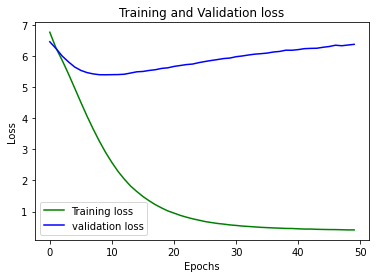

In [ ]:
# Plotting a loss curve to see if we need this many epochs
# Looks to still be decreasing slowly
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

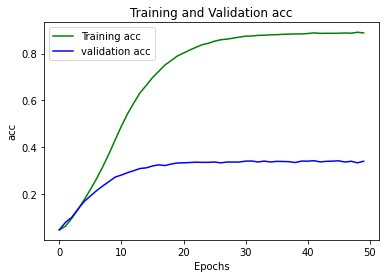

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(50)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/lstm-basic-validation2')


In [ ]:

# Create a function to generate 'next_words' number of words on top of the seeded bar
def generateraplyrics(next_words):
  seed_text  = random.choice(kept_bars)
  #print(seed_text)
  token_list = sentence_to_integer(seed_text)
  token_list = pad_sequences([token_list], maxlen = padding_length - 1, padding = 'pre')
  predicted  = np.argmax(model.predict(token_list), axis=-1)
  lyrics1 = int_to_word[predicted[0]]
  lyrics = [lyrics1]
  #print(lyrics)
  for _ in range(next_words):
      token_list = sentence_to_integer(lyrics)
      #print(token_list)
      token_list = pad_sequences([token_list], maxlen = padding_length - 1, padding = 'pre')
      #print(token_list)
      predicted  = np.argmax(model.predict(token_list), axis=-1)
      #print(predicted)
      lyrics1 += ' ' + int_to_word[predicted[0]]
      lyrics = lyrics1.split()
      #print(lyrics1)
  return lyrics1.capitalize()

In [ ]:
# Example of output with 4000 words generated 
for i in range(80):
  print(generateraplyrics(49))

In [ ]:
for i in range(10):
  print(generateraplyrics(15))

My name is snoop doggy dogg i'm in the top of the stack in some groupie
A lot of money, make y'all wanna come get me get me down and party run
Snoop dogg without is that trick he doin too much way baby much baby much baby
Holla at me ninja holla at ya minutes ninja on us times at da long ghetto
Without my gun in the dirty 213 is no gangsta talk poop to me to do
My name is snoop doggy dogg i'm in the top of the stack in some groupie
But if you keep on teasin me girl, i'm gon' be your man man your plan
Shoes what am i to do when life y'all up, i want to do this poop
My name is snoop doggy dogg i'm in the top of the stack in some groupie
In the world if ya was at me motherfricker i know it to be to your
